<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/tfr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Performace History

1.   Cosidering life expectancy as input
      
      1. *Training using max no of countries:*\
          **MSE**: 1.421960711479187
          
      2. *Training using min no of countries:*\
          **MSE**: 1.6800711154937744

      3. *Training using only common countries:*\
          **MSE**: 1.5712116956710815

2.   Not cosidering life expectancy as input
      1. *Trained using max no of countries:*\
          **MSE**: 1.9395439624786377

      2. *Trained using min no of countries*:\
          **MSE**: 2.161480665206909

      3. *Trained using only common countries*:\
          **MSE**: 2.10016131401062



In [1]:
!rm -rf education-impact
!rm education-impact

rm: cannot remove 'education-impact': No such file or directory


In [2]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 318 (delta 157), reused 157 (delta 46), pack-reused 0
Receiving objects: 100% (318/318), 2.11 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [3]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

     |████████████████████████████████| 17.1 MB 338 kB/s 


In [4]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

In [5]:
#@title Default title text
root = "education-impact/" 
datasets_path = {
                    "infant_mortality"              :  root+ "datasets/Infant_Mortality_Rate.csv",
                    "child_mortality"               :  root+ "datasets/child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"            :  root+ "datasets/children_per_woman_total_fertility.csv",
                    "co2_emissions"                 :  root+ "datasets/co2_emissions_tonnes_per_person.csv",
                    "population"                    :  root+ "datasets/converted_pop.csv",
                    "food_supply"                   :  root+ "datasets/food_supply_kilocalories_per_person_and_day.csv",
                    "gdp_growth"                    :  root+ "datasets/gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"          :  root+ "datasets/mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"  :  root+ "datasets/gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                    :  root+ "datasets/gini.csv",
                    "life_expectancy"               :  root+ "datasets/life_expectancy_years.csv",
                    "malnutrition"                  :  root+ "datasets/malnutrition_weight_for_age_percent_of_children_under_5.csv",
                    "poverty_index"                 :  root+ "datasets/mincpcap_cppp.csv",
                    "maternal_mortality"            :  root+ "datasets/mmr_who.csv",
                    "people_in_poverty"             :  root+ "datasets/number_of_people_in_poverty.csv",
                    "primary_completion"            :  root+ "datasets/primary_school_completion_percent_of_girls.csv",
                    "ratio_b/g_in_primary"          :  root+ "datasets/ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                   :  root+ "datasets/wcde-25--34.csv",
                    "wcde-Incomplete_Primary"       :  root+ "datasets/wcde-Incomplete Primary.csv",
                    "wcde-Lower_Secondary"          :  root+ "datasets/wcde-Lower Secondary.csv",
                    "wcde-Post_Secondary"           :  root+ "datasets/wcde-Post Secondary.csv",
                    "wcde_female-Incomplete_Primary":  root+ "datasets/wcde_female-Incomplete Primary.csv",
                    "wcde_female-Lower_Secondary"   :  root+ "datasets/wcde_female-Lower Secondary.csv",
                    "wcde_female-Post_Secondary"    :  root+ "datasets/wcde_female-Post Secondary.csv",
                    "wcde-In_Primary_OL"            :  root+ "datasets/wcde-In_Primary_OL.csv",
                    "wcde-Primary_OL"               :  root+ "datasets/wcde-Primary_OL.csv",
                    "wcde-Lower_Secondary_OL"       :  root+ "datasets/wcde-Lower_Secondary_OL.csv",
                    "female_wcde-In_Primary_OL"     :  root+ "datasets/wcde-female_In_Primary_OL.csv",
                    "female_wcde-Primary_OL"        :  root+ "datasets/wcde-female_Primary_OL.csv",
                    "female_wcde-Lower_Secondary_OL":  root+ "datasets/wcde-female_Lower_Secondary_OL.csv"
                }

In [85]:
datasets = [
            "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            "children_per_woman",
            "co2_emissions",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "wcde-In_Primary_OL",
            "wcde-Primary_OL",
            # "wcde-Lower_Secondary_OL",
            "population",
            "female_wcde-In_Primary_OL",
            "female_wcde-Primary_OL" ,
            # "female_wcde-Lower_Secondary_OL"
            ]

In [58]:
PREDICT_FUTURE  = 10
OUTPUTS         = ['children_per_woman']
                   

In [86]:
# to find out how many countries each dataset has
countries_count      = None
least_dataset_path   = None
for dataset in datasets:
  df = pd.read_csv(datasets_path[dataset])
  count = len(set(df.Country.unique()))
  if not countries_count:
    countries_count = count
    least_dataset_path   = datasets_path[dataset]
  elif countries_count > count:
    countries_count = count
    least_dataset_path   = datasets_path[dataset]
  print(f"{'Factor: ' + dataset:<30} count: {count}")
print(f"{'To use: ' + least_dataset_path:<30} count: {countries_count}")

Factor: infant_mortality       count: 266
Factor: life_expectancy        count: 195
Factor: children_per_woman     count: 202
Factor: co2_emissions          count: 194
Factor: gini_index             count: 195
Factor: gdppercapita_us_infla_adjust count: 207
Factor: wcde-In_Primary_OL     count: 202
Factor: wcde-Primary_OL        count: 202
Factor: population             count: 197
Factor: female_wcde-In_Primary_OL count: 202
Factor: female_wcde-Primary_OL count: 202
To use: education-impact/datasets/co2_emissions_tonnes_per_person.csv count: 194


In [87]:
common_countries = set()
for dataset in datasets:
  countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
  countries_list = set(map(lambda x: x.lower(), countries_list))
  if common_countries == set():
    common_countries = countries_list
  else:
    common_countries = common_countries.intersection(countries_list)
len(common_countries)

153

In [88]:
# creating a list of all countries & years
countries = list(common_countries)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]

In [62]:
len(countries)

158

In [89]:
keys=[]
for y in years:
  for c in countries:
    keys.append((c,str(y)))

In [90]:
big_dic = {k : [] for k in keys}
for dataset in datasets:
  df = pd.read_csv(datasets_path[dataset])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for k in keys:
    try:
      big_dic[k].append(df.loc[k[0]][k[1]])
    except:
      big_dic[k].append(np.NaN)
 

In [91]:
for output_path in OUTPUTS:
  df = pd.read_csv(datasets_path[output_path])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for k in keys:
    try:
      big_dic[k].append(df.loc[k[0]][str(int(k[1])+PREDICT_FUTURE)])
    except:
      big_dic[k].append(np.NaN)

In [92]:
columns = [k for k in datasets ]
output_columns = ["o_"+o for o in OUTPUTS]
columns.extend(output_columns)

In [93]:
input_df = pd.DataFrame.from_dict(big_dic,orient='index', columns = columns)
output_df = input_df[["o_"+o for o in OUTPUTS]]
input_df.drop(labels=["o_"+o for o in OUTPUTS], axis = 1, inplace=True)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

In [95]:
X_train.isna().sum()

infant_mortality                 529
life_expectancy                    0
children_per_woman                 0
co2_emissions                    107
gini_index                         0
gdppercapita_us_infla_adjust    1280
wcde-In_Primary_OL                 0
wcde-Primary_OL                    0
population                         0
female_wcde-In_Primary_OL          0
female_wcde-Primary_OL             0
dtype: int64

In [96]:
y_train.isna().sum()

o_children_per_woman    0
dtype: int64

In [71]:
X_train

,life_expectancy,co2_emissions,gini_index,gdppercapita_us_infla_adjust,wcde-In_Primary_OL,wcde-Primary_OL,population,female_wcde-In_Primary_OL,female_wcde-Primary_OL
"(malta, 1966)",70.0,1.280,28.0,NaN,1.70,62.56,323000,1.70,62.56
"(turkey, 1963)",51.9,0.767,51.3,2720.0,57.48,91.66,29500000,57.48,91.66
"(guinea-bissau, 1987)",47.2,0.213,46.0,607.0,91.28,94.96,913000,91.28,94.96
"(cuba, 2005)",77.7,2.300,42.8,5180.0,1.10,8.80,11300000,1.10,8.80
"(benin, 1986)",54.3,0.151,41.7,833.0,83.60,92.60,4400000,83.60,92.60
...,...,...,...,...,...,...,...,...,...
"(zimbabwe, 1999)",48.5,1.330,40.2,1760.0,11.92,29.68,11800000,11.92,29.68
"(south sudan, 1974)",52.0,0.123,45.0,NaN,93.68,99.80,3840000,93.68,99.80
"(trinidad and tobago, 1974)",66.6,10.100,48.3,6650.0,14.90,48.66,996000,14.90,48.66
"(armenia, 1981)",70.5,5.460,41.5,NaN,0.20,0.78,3150000,0.20,0.78


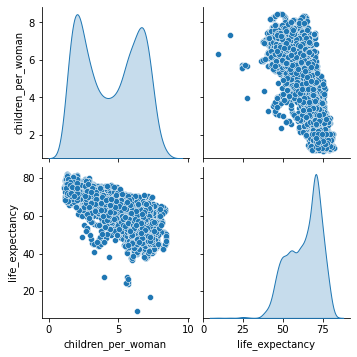

In [97]:
sns.pairplot(X_train[["children_per_woman","life_expectancy"]], diag_kind="kde")

In [73]:
# sns.pairplot(X_train[["infant_mortality","Avg_daily_income_ppp"]], diag_kind="kde")

In [74]:
# sns.pairplot(X_train[["infant_mortality","wcde-Incomplete_Primary"]], diag_kind="kde")

In [75]:
# sns.pairplot(X_train[["infant_mortality","population"]], diag_kind="kde")

In [76]:
y_train

,o_children_per_woman
"(malta, 1966)",2.08
"(turkey, 1963)",5.32
"(guinea-bissau, 1987)",6.11
"(cuba, 2005)",1.72
"(benin, 1986)",6.28
...,...
"(zimbabwe, 1999)",4.02
"(south sudan, 1974)",6.81
"(trinidad and tobago, 1974)",3.15
"(armenia, 1981)",2.48


In [77]:
def combine_dfs(label,X,y):
  frames      = [X,y[label]]
  le_model_df = pd.concat(frames,axis=1)
  le_model_df.dropna(subset=[label],inplace=True)
  return le_model_df

In [78]:
combine_dfs("o_"+OUTPUTS[0],X_test,y_test)

,life_expectancy,co2_emissions,gini_index,gdppercapita_us_infla_adjust,wcde-In_Primary_OL,wcde-Primary_OL,population,female_wcde-In_Primary_OL,female_wcde-Primary_OL,o_children_per_woman
"(gambia, 1963)",54.6,0.0757,39.6,NaN,96.88,97.70,388000,96.88,97.70,6.23
"(belarus, 1974)",72.5,9.7300,22.4,NaN,0.24,2.74,9190000,0.24,2.74,2.11
"(guinea-bissau, 1992)",49.4,0.1760,44.7,679.0,86.36,92.08,1020000,86.36,92.08,5.64
"(angola, 1975)",47.5,0.6280,54.4,NaN,94.80,97.90,7020000,94.80,97.90,7.38
"(mauritius, 1960)",58.1,0.2720,38.6,NaN,69.30,92.60,660000,69.30,92.60,3.95
...,...,...,...,...,...,...,...,...,...,...
"(kuwait, 1977)",70.0,14.9000,40.0,NaN,45.78,58.90,1150000,45.78,58.90,3.78
"(azerbaijan, 1993)",64.3,6.3900,34.0,1620.0,0.24,0.88,7580000,0.24,0.88,1.87
"(czech republic, 2004)",76.1,12.5000,27.1,14100.0,0.40,0.60,10200000,0.40,0.60,1.51
"(nepal, 1970)",49.3,0.0188,32.0,351.0,94.80,97.10,12100000,94.80,97.10,5.73


In [79]:
for output in OUTPUTS:
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs("o_"+output,X_train,y_train), label="o_"+output, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  
  model.fit(x=train_ds)
  # Convert it to a TensorFlow dataset
  test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs("o_"+output,X_train,y_train), label="o_"+output, task=tfdf.keras.Task.REGRESSION)

  # Evaluate the model
  model.compile(metrics=["mse"])
  # Evaluate the model on the test dataset.
  evaluation = model.evaluate(test_ds, return_dict=True)
  print(output.upper())
  print(evaluation)
  print()
  print(f"MSE: {evaluation['mse']}")
  print(f"RMSE: {math.sqrt(evaluation['mse'])}")
  print()

80/80 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mse: 0.0448
CHILDREN_PER_WOMAN
{'loss': 0.0, 'mse': 0.04476310685276985}

MSE: 0.04476310685276985
RMSE: 0.21157293506677516



In [84]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=132)

In [81]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (9):
	co2_emissions
	female_wcde-In_Primary_OL
	female_wcde-Primary_OL
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population
	wcde-In_Primary_OL
	wcde-Primary_OL

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                      "__LABEL" 11.388247 ################
    2. "gdppercapita_us_infla_adjust"  7.840979 ##########
    3.                   "gini_index"  7.077176 ########
    4.                "co2_emissions"  6.346788 #######
    5.       "female_wcde-Primary_OL"  6.085241 #######
    6.              "wcde-Primary_OL"  5.950092 #######
    7.                   "population"  5.847507 ######
    8.

# CNN Algorithm

from the above output
- **malnutrition & people in povery** have least no of countries
- **infant mortality & gdp per captia** have highest no of countries

*Doubt:* Does having more data for one factor will make the decision tree bias?


###Steps
1. create a csv file such that each row contains all values of particular year & country present
2. the output for each row is year + 40 years corresponding value 
    1. **outputs** - life expectany, education level, gdp




From above output
- if we dont drop any rows our table size = 4256 entries
- if we drop rows containing any if all of outputs missing then our table size = 3039 entries
- if we drop rows containing any one of output missing then our table size = 1745 entries

so, I think its is better to go with second choice and build different models, but not sure it will not effect performance of the model


now we have the dataframe containing both inputs and ouputs,our next step is
1. split the data into train & test data
  1. try to split data based on continents to reduce bias
2. build DF model using tensorflow
3. check the accuracy of the model